# Modeling 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

## caricamento dei dati 

In [13]:
df = pd.read_csv('ai_human_with_signatures.csv')
print(f"Dataset caricato: {df.shape[0]} righe × {df.shape[1]} colonne")

Dataset caricato: 500 righe × 50 colonne


## feature selection strategica

In [14]:
# Feature stilometriche pure (NO leakage semantico)
stylometric_features = [
    # Signature avanzate (R-S-L-D-E-C)
    'sentence_length_cv',
    'burstiness_index',
    'pos_bigram_entropy',
    'dependency_depth_mean',
    'lexical_compression_ratio',
    'function_word_ratio',
    'sentence_similarity_drift',
    'structural_redundancy',
    'sentiment_variance',
    'readability_oscillation',
    'clause_density',
    
    # Feature linguistiche base
    'avg_word_length',
    'lexical_diversity',
    'punctuation_density',
    'exclamation_count',
    'question_count',
    'sentence_count',
    'avg_sentence_length',
    'type_token_ratio',
    
    # Firme stilistiche
    'hedge_words_count',
    'intensifier_count',
    'first_person_count',
    'contraction_density',
    
    # Readability
    'readability_score',
    'grade_level',
    
    # Sintattiche
    'passive_voice_ratio',
    'unique_bigram_ratio',
    'sentence_length_variability',
    
    # Named Entities
    'entity_density',
    'person_entity_count',
    'org_entity_count',
    'location_entity_count'
]

In [15]:
# Verifica disponibilità feature
available_features = [f for f in stylometric_features if f in df.columns]
missing_features = [f for f in stylometric_features if f not in df.columns]

print(f"Feature disponibili: {len(available_features)}/{len(stylometric_features)}")
if missing_features:
    print(f"⚠️  Feature mancanti: {', '.join(missing_features[:5])}...")


Feature disponibili: 32/32


### variabile dipendente e indipendente

In [16]:
X = df[available_features].fillna(0)  
y = df['label_encoded']

print(f"\nDistribuzione target:")
print(y.value_counts(normalize=True).round(3))
print(f"   Human (0): {(y==0).sum()} campioni")
print(f"   AI (1): {(y==1).sum()} campioni")


Distribuzione target:
label_encoded
1    0.502
0    0.498
Name: proportion, dtype: float64
   Human (0): 249 campioni
   AI (1): 251 campioni


## split into the train and test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f" Train set: {X_train.shape[0]} campioni")
print(f"Test set:  {X_test.shape[0]} campioni")


 Train set: 400 campioni
Test set:  100 campioni


## standardizzazione

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardizzazione completata (mean=0, std=1)")


Standardizzazione completata (mean=0, std=1)


## TRAINING MULTI-MODELLO

In [19]:
print("\n[5/8] Training modelli...")
print("-"*70)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        penalty='l2',
        C=1.0
    )
}



[5/8] Training modelli...
----------------------------------------------------------------------


In [20]:
results = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    
    # Training
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metriche
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    if 'Logistic' in name:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                     cv=cv, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, 
                                     cv=cv, scoring='roc_auc')
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"   ROC-AUC (Test): {roc_auc:.4f}")
    print(f"   F1-Score:       {f1:.4f}")
    print(f"   CV ROC-AUC:     {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



🔧 Training Random Forest...
   ROC-AUC (Test): 1.0000
   F1-Score:       0.9899
   CV ROC-AUC:     0.9982 ± 0.0035

🔧 Training Gradient Boosting...
   ROC-AUC (Test): 0.9990
   F1-Score:       0.9697
   CV ROC-AUC:     0.9836 ± 0.0145

🔧 Training Logistic Regression...
   ROC-AUC (Test): 1.0000
   F1-Score:       1.0000
   CV ROC-AUC:     0.9998 ± 0.0005


In [21]:
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']

print("\n" + "="*70)
print(f" MIGLIOR MODELLO: {best_model_name}")
print(f"   ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print("="*70)


 MIGLIOR MODELLO: Random Forest
   ROC-AUC: 1.0000


## 6. ANALISI DETTAGLIATA MIGLIOR MODELLO

In [22]:
print(f"\n Analisi dettagliata: {best_model_name}")
print("-"*70)

y_pred_best = results[best_model_name]['y_pred']
y_pred_proba_best = results[best_model_name]['y_pred_proba']

# Classification Report
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Human', 'AI'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\n CONFUSION MATRIX:")
print(f"                Predicted")
print(f"              Human    AI")
print(f"Actual Human   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       AI      {cm[1,0]:4d}  {cm[1,1]:4d}")

# Metriche derivate
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\n METRICHE AGGIUNTIVE:")
print(f"   Sensitivity (Recall):  {sensitivity:.4f}")
print(f"   Specificity:           {specificity:.4f}")



 Analisi dettagliata: Random Forest
----------------------------------------------------------------------

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Human     0.9804    1.0000    0.9901        50
          AI     1.0000    0.9800    0.9899        50

    accuracy                         0.9900       100
   macro avg     0.9902    0.9900    0.9900       100
weighted avg     0.9902    0.9900    0.9900       100


 CONFUSION MATRIX:
                Predicted
              Human    AI
Actual Human     50     0
       AI         1    49

 METRICHE AGGIUNTIVE:
   Sensitivity (Recall):  0.9800
   Specificity:           1.0000


## 7. FEATURE IMPORTANCE

In [ ]:
print(f"\n[7/8] Analisi Feature Importance...")

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("\n TOP 10 FEATURE PIÙ IMPORTANTI:")
    for i, idx in enumerate(indices[:10], 1):
        print(f"   {i:2d}. {available_features[idx]:30s} {importances[idx]:.4f}")
    
    feature_importance_data = pd.DataFrame({
        'feature': available_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

elif hasattr(best_model, 'coef_'):
    # Linear models
    coefficients = np.abs(best_model.coef_[0])
    indices = np.argsort(coefficients)[::-1]
    
    print("\n TOP 10 FEATURE PIÙ INFLUENTI:")
    for i, idx in enumerate(indices[:10], 1):
        coef_sign = '+' if best_model.coef_[0][idx] > 0 else '-'
        print(f"   {i:2d}. {available_features[idx]:30s} {coef_sign}{coefficients[idx]:.4f}")
    
    feature_importance_data = pd.DataFrame({
        'feature': available_features,
        'importance': coefficients
    }).sort_values('importance', ascending=False)


[7/8] Analisi Feature Importance...

🎯 TOP 10 FEATURE PIÙ IMPORTANTI:
    1. first_person_count             0.3127
    2. punctuation_density            0.2207
    3. dependency_depth_mean          0.0751
    4. pos_bigram_entropy             0.0484
    5. avg_sentence_length            0.0437
    6. hedge_words_count              0.0429
    7. avg_word_length                0.0403
    8. function_word_ratio            0.0354
    9. grade_level                    0.0193
   10. clause_density                 0.0174


### 8. VISUALIZZAZIONI


[8/8] Generazione visualizzazioni...
✅ Visualizzazione salvata: 'model_performance_analysis.png'


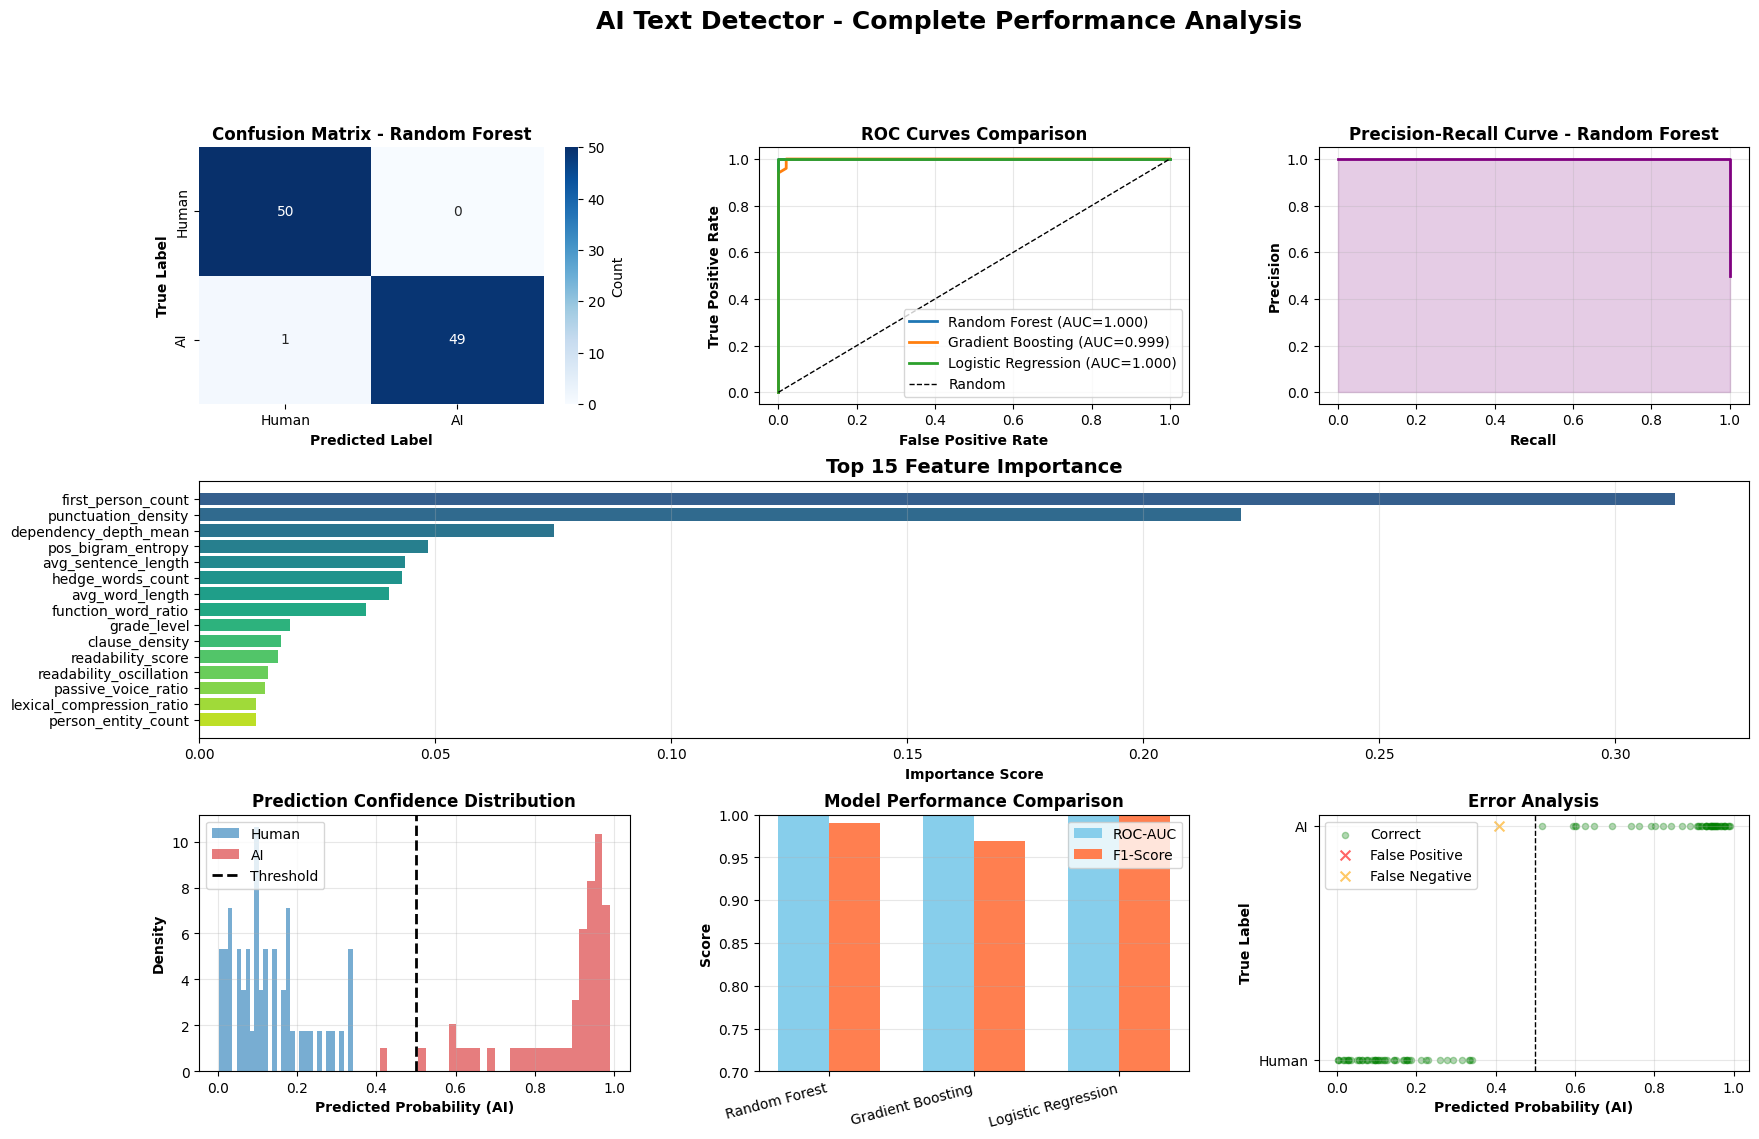

In [24]:
print("\n[8/8] Generazione visualizzazioni...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# Plot 2: ROC Curves (tutti i modelli)
ax2 = fig.add_subplot(gs[0, 1])
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    ax2.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})", linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('ROC Curves Comparison', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
ax3.plot(recall, precision, linewidth=2, color='purple')
ax3.fill_between(recall, precision, alpha=0.2, color='purple')
ax3.set_xlabel('Recall', fontweight='bold')
ax3.set_ylabel('Precision', fontweight='bold')
ax3.set_title(f'Precision-Recall Curve - {best_model_name}', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance (Top 15)
ax4 = fig.add_subplot(gs[1, :])
top_features = feature_importance_data.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
bars = ax4.barh(range(len(top_features)), top_features['importance'], color=colors)
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.set_xlabel('Importance Score', fontweight='bold')
ax4.set_title('Top 15 Feature Importance', fontweight='bold', fontsize=14)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Prediction Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_pred_proba_best[y_test == 0], bins=30, alpha=0.6, 
         label='Human', color='#1f77b4', density=True)
ax5.hist(y_pred_proba_best[y_test == 1], bins=30, alpha=0.6, 
         label='AI', color='#d62728', density=True)
ax5.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax5.set_xlabel('Predicted Probability (AI)', fontweight='bold')
ax5.set_ylabel('Density', fontweight='bold')
ax5.set_title('Prediction Confidence Distribution', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(alpha=0.3)

# Plot 6: Model Comparison (Bar Chart)
ax6 = fig.add_subplot(gs[2, 1])
model_names = list(results.keys())
roc_scores = [results[name]['roc_auc'] for name in model_names]
f1_scores = [results[name]['f1'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax6.bar(x - width/2, roc_scores, width, label='ROC-AUC', color='skyblue')
bars2 = ax6.bar(x + width/2, f1_scores, width, label='F1-Score', color='coral')

ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
ax6.set_xticks(x)
ax6.set_xticklabels(model_names, rotation=15, ha='right')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim(0.7, 1.0)

# Plot 7: Error Analysis
ax7 = fig.add_subplot(gs[2, 2])
errors_df = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best,
    'Confidence': y_pred_proba_best
})
errors_df['Error'] = errors_df['True'] != errors_df['Predicted']

# False Positives e False Negatives
fp_indices = (y_test == 0) & (y_pred_best == 1)
fn_indices = (y_test == 1) & (y_pred_best == 0)

ax7.scatter(y_pred_proba_best[~(fp_indices | fn_indices)], 
           y_test[~(fp_indices | fn_indices)], 
           alpha=0.3, s=20, color='green', label='Correct')
ax7.scatter(y_pred_proba_best[fp_indices], 
           y_test[fp_indices], 
           alpha=0.6, s=50, color='red', marker='x', label='False Positive')
ax7.scatter(y_pred_proba_best[fn_indices], 
           y_test[fn_indices], 
           alpha=0.6, s=50, color='orange', marker='x', label='False Negative')
ax7.axvline(0.5, color='black', linestyle='--', linewidth=1)
ax7.set_xlabel('Predicted Probability (AI)', fontweight='bold')
ax7.set_ylabel('True Label', fontweight='bold')
ax7.set_yticks([0, 1])
ax7.set_yticklabels(['Human', 'AI'])
ax7.set_title('Error Analysis', fontweight='bold', fontsize=12)
ax7.legend()
ax7.grid(alpha=0.3)

plt.suptitle('AI Text Detector - Complete Performance Analysis', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Visualizzazione salvata: 'model_performance_analysis.png'")
plt.show()


## Salvataggio

In [25]:
print("\n[9/9] Salvataggio modelli e artefatti...")

# Salva il miglior modello
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"✅ Modello salvato: 'best_model_{best_model_name.replace(' ', '_')}.pkl'")

# Salva lo scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler salvato: 'scaler.pkl'")

# Salva feature list
with open('feature_list.txt', 'w') as f:
    f.write('\n'.join(available_features))
print("✅ Feature list salvata: 'feature_list.txt'")

# Salva feature importance
feature_importance_data.to_csv('feature_importance.csv', index=False)
print("✅ Feature importance salvata: 'feature_importance.csv'")



[9/9] Salvataggio modelli e artefatti...
✅ Modello salvato: 'best_model_Random_Forest.pkl'
✅ Scaler salvato: 'scaler.pkl'
✅ Feature list salvata: 'feature_list.txt'
✅ Feature importance salvata: 'feature_importance.csv'


## riepilogo 

In [26]:
print("\n" + "="*70)
print("✅ PIPELINE COMPLETATA CON SUCCESSO!")
print("="*70)
print(f"\n🏆 MIGLIOR MODELLO: {best_model_name}")
print(f"   • ROC-AUC:        {results[best_model_name]['roc_auc']:.4f}")
print(f"   • F1-Score:       {results[best_model_name]['f1']:.4f}")
print(f"   • CV ROC-AUC:     {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")
print(f"   • Sensitivity:    {sensitivity:.4f}")
print(f"   • Specificity:    {specificity:.4f}")

print("\n📁 FILE GENERATI:")
print("   • model_performance_analysis.png")
print(f"   • best_model_{best_model_name.replace(' ', '_')}.pkl")
print("   • scaler.pkl")
print("   • feature_list.txt")
print("   • feature_importance.csv")

print("\n🔍 ANALISI DEGLI ERRORI:")
print(f"   • False Positives (Human → AI): {fp}")
print(f"   • False Negatives (AI → Human): {fn}")
print(f"   • Total Errors: {fp + fn} / {len(y_test)} ({(fp+fn)/len(y_test)*100:.2f}%)")

print("\n🎯 PROSSIMI STEP SUGGERITI:")
print("   1. Analisi SHAP values per interpretabilità")
print("   2. Test su dataset esterni (robustness check)")
print("   3. Analisi degli errori per identificare pattern problematici")
print("   4. Hyperparameter tuning con GridSearchCV/Optuna")
print("   5. Ensemble di modelli per migliorare performance")

print("\n" + "="*70)


✅ PIPELINE COMPLETATA CON SUCCESSO!

🏆 MIGLIOR MODELLO: Random Forest
   • ROC-AUC:        1.0000
   • F1-Score:       0.9899
   • CV ROC-AUC:     0.9982 ± 0.0035
   • Sensitivity:    0.9800
   • Specificity:    1.0000

📁 FILE GENERATI:
   • model_performance_analysis.png
   • best_model_Random_Forest.pkl
   • scaler.pkl
   • feature_list.txt
   • feature_importance.csv

🔍 ANALISI DEGLI ERRORI:
   • False Positives (Human → AI): 0
   • False Negatives (AI → Human): 1
   • Total Errors: 1 / 100 (1.00%)

🎯 PROSSIMI STEP SUGGERITI:
   1. Analisi SHAP values per interpretabilità
   2. Test su dataset esterni (robustness check)
   3. Analisi degli errori per identificare pattern problematici
   4. Hyperparameter tuning con GridSearchCV/Optuna
   5. Ensemble di modelli per migliorare performance

